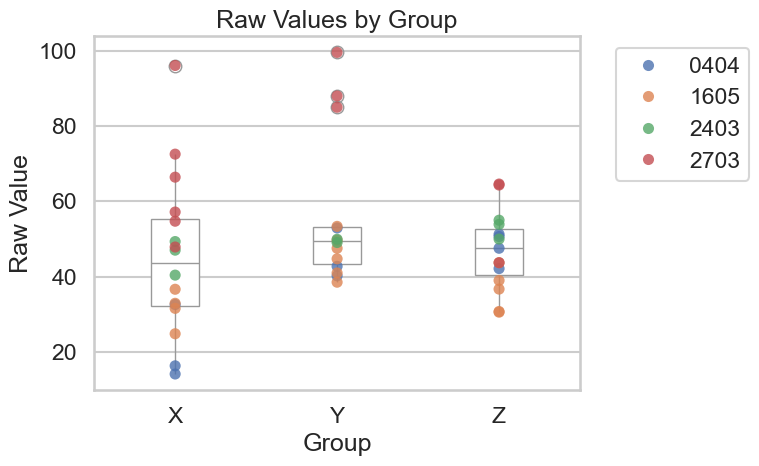

C:\Users\jmcd0002\AppData\Local\Temp\ipykernel_10692\1489893317.py:128: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


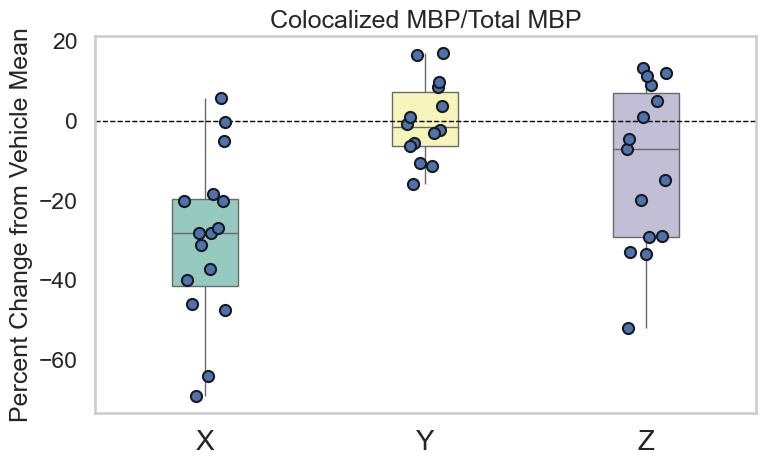

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: PercentChange
No. Observations: 45      Method:             REML         
No. Groups:       4       Scale:              290.6463     
Min. group size:  8       Log-Likelihood:     -184.3300    
Max. group size:  15      Converged:          Yes          
Mean group size:  11.2                                     
-----------------------------------------------------------
               Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
-----------------------------------------------------------
Intercept       1.290    5.862  0.220 0.826 -10.199  12.779
Group[T.X]    -29.992    6.316 -4.748 0.000 -42.372 -17.612
Group[T.Z]    -12.236    6.369 -1.921 0.055 -24.719   0.247
Group Var      49.526    4.103                             



In [4]:
# Logic and structure by Jack McDonald, with coding support from ChatGPT-4.
# Script runs in Python 3.11 or later. 
# Sorry Mat, It's pretty different to the task you asked for but hopefully it demonsrates the neccessary competency? 
# thanks for showing me python it is already really helpul for my work. 


import matplotlib.pyplot as plt
import numpy as np
import os
import glob  
from skimage.morphology import remove_small_objects, binary_opening
from skimage.io import imread
from scipy.ndimage import binary_dilation
import pandas as pd

# Input and output directories
# Set relative paths assuming script is in the repo root
maskDir = os.path.join("data")
output_dir = os.path.join("output")

os.makedirs(output_dir, exist_ok=True)
# --- Match FIB and MBP Masks ---
fList = glob.glob(os.path.join(maskDir, "*.tif"))
fib_dict = {
    os.path.basename(f).replace("Max_Fib_Mask_", "").replace(".tif", ""): f
    for f in fList if os.path.basename(f).startswith("Max_Fib")
}
mbp_dict = {
    os.path.basename(f).replace("Max_MBP_Mask_", "").replace(".tif", ""): f
    for f in fList if os.path.basename(f).startswith("Max_MBP")
}
matching_keys = sorted(set(fib_dict.keys()) & set(mbp_dict.keys()))

results = []

for key in matching_keys:
    fib_img = imread(fib_dict[key])
    mbp_img = imread(mbp_dict[key])

    # Thresholding and binary mask creation
    fib_img = np.where(fib_img > 1, 255, 0).astype(np.uint8)
    fib_img = 255 - fib_img
    fib_img = binary_opening(fib_img)
    fib_img = remove_small_objects(fib_img, min_size=1000)

    mbp_img = np.where(mbp_img > 1, 255, 0).astype(np.uint8)
    mbp_img = 255 - mbp_img
    mbp_img = remove_small_objects(mbp_img, min_size=300)

    fib_mask = fib_img.astype(bool)
    mbp_mask = mbp_img.astype(bool)

    overlap = mbp_mask & fib_mask
    percent_colocalized = 100 * np.sum(overlap) / np.sum(mbp_mask) if np.sum(mbp_mask) > 0 else np.nan

    results.append({
        'filename': key,
        'percent_colocalized': percent_colocalized,
        'mbp_area': np.sum(mbp_mask),
        'fib_area': np.sum(fib_mask),
        'overlap_area': np.sum(overlap)
    })

# --- Save Results (wide format) ---
df = pd.DataFrame(results)
df.to_csv(os.path.join(output_dir, "mbp_fib_colocalization_metrics.csv"), index=False)

# --- Convert to long format ---
def extract_group(filename):
    return filename[0]

def extract_replicate(filename):
    import re
    match = re.search(r'(\d{4})', filename)
    return match.group(1) if match else filename

long_df = pd.DataFrame({
    "Group": [extract_group(row['filename']) for row in results],
    "Replicate": [extract_replicate(row['filename']) for row in results],
    "Value": [row['percent_colocalized'] for row in results]
})
long_df.to_csv(os.path.join(output_dir, "mbp_fib_colocalization_long.csv"), index=False)

# --- Analysis and Plotting ---
import seaborn as sns
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.formula.api as smf

sns.set(style="whitegrid", context="talk")

# Load and clean data
df = long_df.copy()
df.columns = df.columns.str.strip()
df = df.dropna(subset=["Group", "Replicate", "Value"]).reset_index(drop=True)
df["Replicate"] = df["Replicate"].astype(str)

# Normalization by vehicle
control_group = "Y"
vehicle_means = df[df["Group"] == control_group].groupby("Replicate")["Value"].mean()

def normalize_percent(row):
    rep = row["Replicate"]
    if rep in vehicle_means:
        baseline = vehicle_means[rep]
        return ((row["Value"] - baseline) / baseline * 100)
    else:
        return None

df["PercentChange"] = df.apply(normalize_percent, axis=1)

# --- Plot: Raw Values ---
plt.figure(figsize=(8, 5))
sns.stripplot(data=df, x="Group", y="Value", hue="Replicate", dodge=False, jitter=False, alpha=0.8, size=8)
sns.boxplot(data=df, x="Group", y="Value", color="white", width=0.3, showcaps=False)
plt.title("Raw Values by Group")
plt.ylabel("Raw Value")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# --- Plot: Percent Change from Vehicle ---
group_order = df["Group"].unique().tolist()
df_valid = df[df["Group"].notna()]

plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df_valid, x="Group", y="PercentChange", palette="Set3", color="white",
    width=0.3, showcaps=False, order=group_order
)
sns.stripplot(
    data=df_valid, x="Group", y="PercentChange",
    dodge=False, jitter=True, size=8, order=group_order,
    marker="o", linewidth=1.5, edgecolor="k", alpha=1
)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title("Colocalized MBP/Total MBP")
plt.ylabel("Percent Change from Vehicle Mean")
plt.xticks(fontsize=20)
plt.xlabel("")
plt.legend([], [], frameon=False)
plt.grid(False)
plt.tight_layout()
plt.gcf().patch.set_alpha(0)
plt.gca().patch.set_alpha(0)
plt.show()

# --- Statistics: Mixed Linear Model ---
df["Group"] = pd.Categorical(df["Group"], categories=["Y", "X", "Z"], ordered=True)
model = smf.mixedlm("PercentChange ~ Group", data=df, groups=df["Replicate"])
result = model.fit()
print(result.summary())
with open(os.path.join(output_dir, "mixed_model_summary.txt"), "w") as f:
    f.write(str(result.summary()))

